# 场景生成

In [92]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [93]:
!unset http_proxy && unset https_proxy

In [2]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from pipeline_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline

from transformers import AutoTokenizer, PretrainedConfig
import torch
import os.path as osp

In [3]:
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel
        return CLIPTextModel
    
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation
        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")

In [7]:
ctrl_path = './rege_ctrl'

controlnet = ControlNetModel.from_pretrained(osp.join(ctrl_path, 'controlnet'))

tokenizer = AutoTokenizer.from_pretrained(osp.join(ctrl_path, 'tokenizer'),use_fast=False)


sd_inpainting_model_name = "stabilityai/stable-diffusion-2-inpainting"
# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(sd_inpainting_model_name, None)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(osp.join(ctrl_path, "scheduler"))

text_encoder = text_encoder_cls.from_pretrained(osp.join(ctrl_path, "text_encoder"))

vae = AutoencoderKL.from_pretrained(osp.join(ctrl_path, "vae"))

unet = UNet2DConditionModel.from_pretrained(osp.join(ctrl_path, "unet"))

weight_dtype = torch.float32

pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd_inpainting_model_name,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    safety_checker=None,
    revision=None,
    torch_dtype=weight_dtype,
)

print("End loading")

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')
pipeline.set_progress_bar_config(disable=True)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-inpainting (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f0d65dc1dd0>, 'Connection to huggingface.co timed out. (connect timeout=None)'))"), '(Request ID: 1ce3227f-a46b-44c1-8b2f-a289c4bf7dbf)').
Will try to load from local cache.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 2690.96it/s]


End loading


### Inference

In [8]:
from PIL import Image, ImageOps
import requests
from io import BytesIO

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
img_name = 'imgs/radio.png'

img = Image.open(img_name).convert('RGB')
img_size = (512, 384)
img = resize_with_padding(img, img_size)

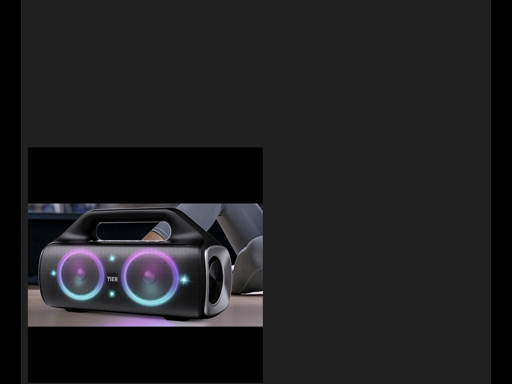

In [9]:
img

/root/miniconda3/envs/rep/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


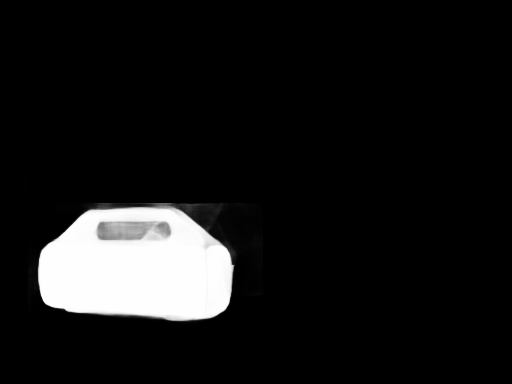

In [10]:
from transparent_background import Remover

# Load model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint
fg_mask = remover.process(img, type='map') # default setting - transparent background
fg_mask

In [23]:
seed = 13
prompt = "A radio is palced on a golden sunshine beach"
mask = ImageOps.invert(fg_mask)

## Background generation using Stable Diffusion without ControlNet (cond_scale=0)

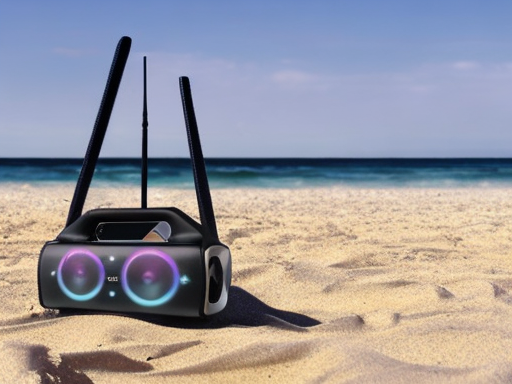

In [24]:
generator = torch.Generator(device='cuda').manual_seed(seed)

cond_scale = 0.0
with torch.autocast("cuda"):
    sd2_image = pipeline(
        prompt=prompt, 
        image=img, 
        mask_image=mask, 
        control_image=mask, 
        num_images_per_prompt=1, 
        generator=generator, 
        num_inference_steps=20, 
        guess_mode=False, 
        controlnet_conditioning_scale=cond_scale
    ).images[0]
sd2_image

## Stable Diffusion with Controlnet (cond_scale = 1)

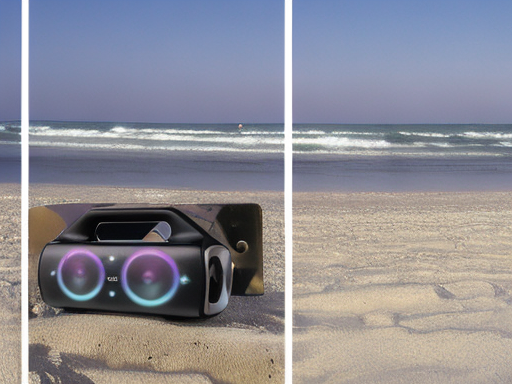

In [25]:
generator = torch.Generator(device='cuda').manual_seed(seed)
cond_scale = 1.0
with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, 
        image=img, 
        mask_image=mask,
        control_image=mask, 
        num_images_per_prompt=1, 
        generator=generator, 
        num_inference_steps=20, 
        guess_mode=False, 
        controlnet_conditioning_scale=cond_scale
    ).images[0]
controlnet_image

# Object Expansion

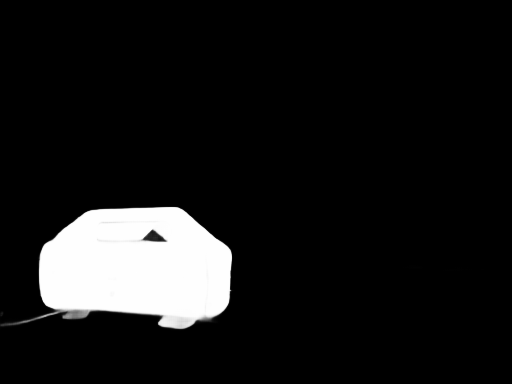

In [20]:
sd2_fg_mask = remover.process(sd2_image, type='map')
sd2_fg_mask

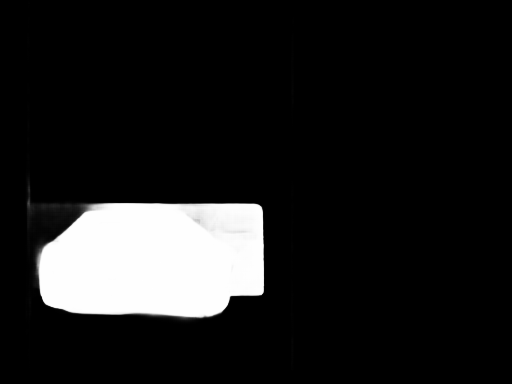

In [21]:
controlnet_fg_mask = remover.process(controlnet_image, type='map')
controlnet_fg_mask

In [91]:
import numpy as np
def obj_expansion(mask_ref, mask_pred):
    mask_pred = np.array(mask_pred)
    mask_ref = np.array(mask_ref)
    
    area_pred = np.mean(mask_pred > 127)
    area_ref = np.mean(mask_ref > 127)
    
    expansion = area_pred - area_ref
    return expansion

Object expansion using ControlNet will be:

In [15]:
obj_expansion(fg_mask, controlnet_fg_mask)

-0.00054168701171875